<a href="https://colab.research.google.com/github/mansimar11/Asteroid_Spectra_ml_dl/blob/main/dl_autoencode_(gaussianmixturemodel)_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import standard libraries
import os

# Import installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Scikit-Learn stuff
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

# Keras
import tensorflow.keras as keras
import tensorflow as tf

# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
# Let's mount the Google Drive, where we store files and models (if applicable, otherwise work
# locally)
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/Colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""

# Load the level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())
asteroids_y_bus = np.array(asteroids_df["Bus_Class"].to_list())

Mounted at /gdrive


In [ ]:
# In this example we create a single test-training split with a ratio of 0.8 / 0.2
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):

    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]
    y_train_bus, y_test_bus = asteroids_y_bus[train_index], asteroids_y_bus[test_index]

In [ ]:
# Import the preprocessing module
from sklearn import preprocessing

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the training data to fit
# the scaler
scaler = preprocessing.StandardScaler().fit(X_train)

# Transform now the training data
X_train_scaled = scaler.transform(X_train)

# Scale the testing data ...
X_test_scaled = scaler.transform(X_test)

# And expanding the dimensionality for our ConvNet-based Autoencoder
X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
X_test_scaled = np.expand_dims(X_test_scaled, axis=2)

In [ ]:
# Get the number of inputs
n_inputs = asteroids_X.shape[1]

# Let's create an autoencoder with a 2-D latent space
n_bottleneck = 5

def create_model():

    # Input layer, this time without a normalisation layer
    input_layer = keras.Input(shape=(n_inputs, 1))

    # Conv Layers (we won't be using maxpooling, since the dimensionaliy is 49 and we do not
    # alter the data in our example
    hidden_layer = keras.layers.Conv1D(filters=16,
                                       activation="relu",
                                       kernel_size=3, padding="same")(input_layer)
    hidden_layer = keras.layers.Conv1D(filters=32,
                                       activation="relu",
                                       kernel_size=3, padding="same")(hidden_layer)

    # Encoder ("Bottleneck" of the Autoencoder)
    bottleneck_lay = keras.layers.Flatten()(hidden_layer)
    bottleneck_lay = keras.layers.Dense(n_bottleneck)(bottleneck_lay)

    # The original shape must be restored and reshaped accordingly
    reset_lay = keras.layers.Dense(49*32)(bottleneck_lay)
    reshape_lay = keras.layers.Reshape((49, 32))(reset_lay)

    # First and second hidden decoder layers
    hidden_layer = keras.layers.Conv1DTranspose(filters=32,
                                                kernel_size=3,
                                                strides=1,
                                                activation="relu",
                                                padding="same")(reshape_lay)
    hidden_layer = keras.layers.Conv1DTranspose(filters=16,
                                                kernel_size=3,
                                                strides=1,
                                                activation="relu",
                                                padding="same")(hidden_layer)

    # Ouput layer (same size as input layer)
    output_layer = keras.layers.Conv1D(1, 1, padding="same")(hidden_layer)

    # Create model
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    # Create encoder model
    encoder_model = keras.models.Model(inputs=input_layer, outputs=bottleneck_lay)

    # We return the model and the encoder
    return model, encoder_model

model, encoder_model = create_model()

# Compile the model and use a regression loss function
model.compile(optimizer='adam', loss='mse')

# Show the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 49, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 49, 16)            64        
                                                                 
 conv1d_1 (Conv1D)           (None, 49, 32)            1568      
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 5)                 7845      
                                                                 
 dense_1 (Dense)             (None, 1568)              9408      
                                                                 
 reshape (Reshape)           (None, 49, 32)            0     

In [ ]:
# Train the model
end_epoch = 500
batch_size = 32

# Early Stopping for our final model
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train_scaled, X_train_scaled,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=0,
                    validation_split=0.25,
                    callbacks=[es_callback])

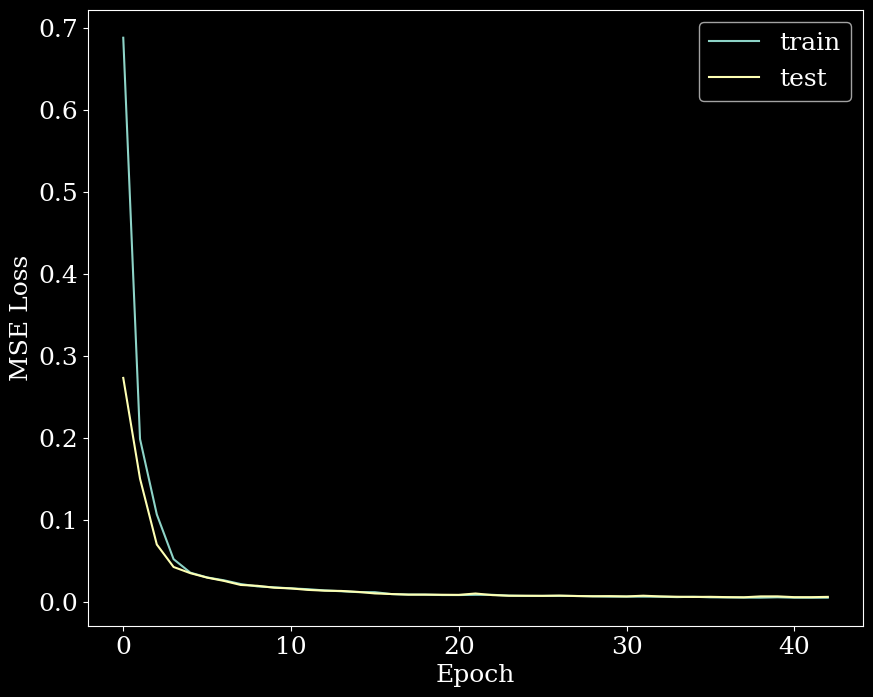

In [ ]:
# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

# plot the training and validation loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

# Add legend and labels
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

# ... aaaaand plot!
plt.show()

34/34 [==============================] - 1s 5ms/step


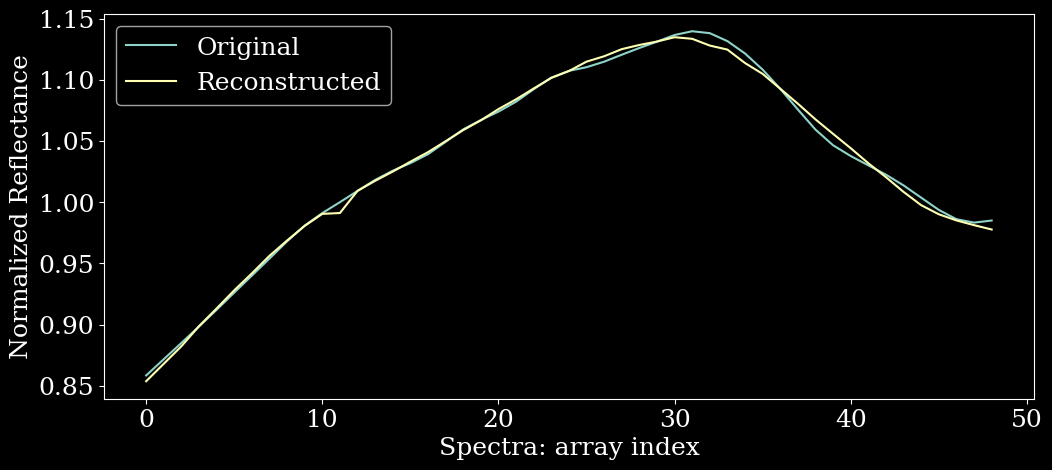

In [ ]:
# Which index shall be displayed?
index_val = 5

# Original signal
org_signal = scaler.inverse_transform(X_train_scaled[index_val].reshape(1, -1))[0]
# Reconstructed signal
rec_signal = scaler.inverse_transform(model.predict(X_train_scaled)[index_val].reshape(1, -1))[0]

# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

# plot the training and reconstructed data
plt.figure(figsize=(12,5))
plt.plot(org_signal, label='Original')
plt.plot(rec_signal, label='Reconstructed')

# Add legend and labels
plt.legend()
plt.xlabel("Spectra: array index")
plt.ylabel("Normalized Reflectance")

# ... aaaaand plot!
plt.show()

In [ ]:
X_train_encoded = encoder_model.predict(X_train_scaled)
X_test_encoded = encoder_model.predict(X_test_scaled)

# Merge the data
X_encoded = np.vstack((X_train_encoded, X_test_encoded))

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the encoded data to fit
# the scaler
enc_scaler = preprocessing.StandardScaler().fit(X_encoded)

# Transform now the encoded data (later used for our scikit-learn method)
X_encoded_scaled = enc_scaler.transform(X_encoded)

# Merge the classes
y_main = np.hstack((y_train, y_test))
y_bus = np.hstack((y_train_bus, y_test_bus))

# Create a column names array for the encoded space
encoder_space = [f"enc{enc_nr+1}" for enc_nr in range(n_bottleneck)]
encoder_space_cols = encoder_space.copy()
encoder_space.extend(["Main_Group", "Bus_Class"])

# Create the dataframe
encoded_df = pd.DataFrame(np.hstack((X_encoded_scaled,
                                     y_main[np.newaxis].transpose(),
                                     y_bus[np.newaxis].transpose())),
                          columns=encoder_space)

# Change the dtype to float
encoded_df.loc[:, encoder_space[:-2]] = encoded_df.loc[:, encoder_space[:-2]].astype(float)

9/9 [==============================] - 0s 4ms/step


In [ ]:
import sklearn.mixture
import tqdm

# Result dataframe that will contain the number of Gaussian components, the Bayesion Information
# Criterion (BIC) and the model itself
gmm_results_df = pd.DataFrame([], columns=["Nr_Comp", "BIC", "Model"])

# We iterate through a number of "component guesses"
max_gauss = 15
for index, gauss_components in tqdm.tqdm(enumerate(np.arange(1, max_gauss+1, 1))):

    # Create and fit a temporary Gaussian Mixture Model
    temp_gmm = sklearn.mixture.GaussianMixture(n_components=gauss_components,
                                               covariance_type="full")
    temp_gmm.fit(X_encoded_scaled)

    # Store the number of components, the BIC and the model
    gmm_results_df.loc[index, "Nr_Comp"] = gauss_components
    gmm_results_df.loc[index, "BIC"] = temp_gmm.bic(X_encoded_scaled)
    gmm_results_df.loc[index, "Model"] = temp_gmm

15it [00:05,  2.69it/s]


(1.0, 15.0)

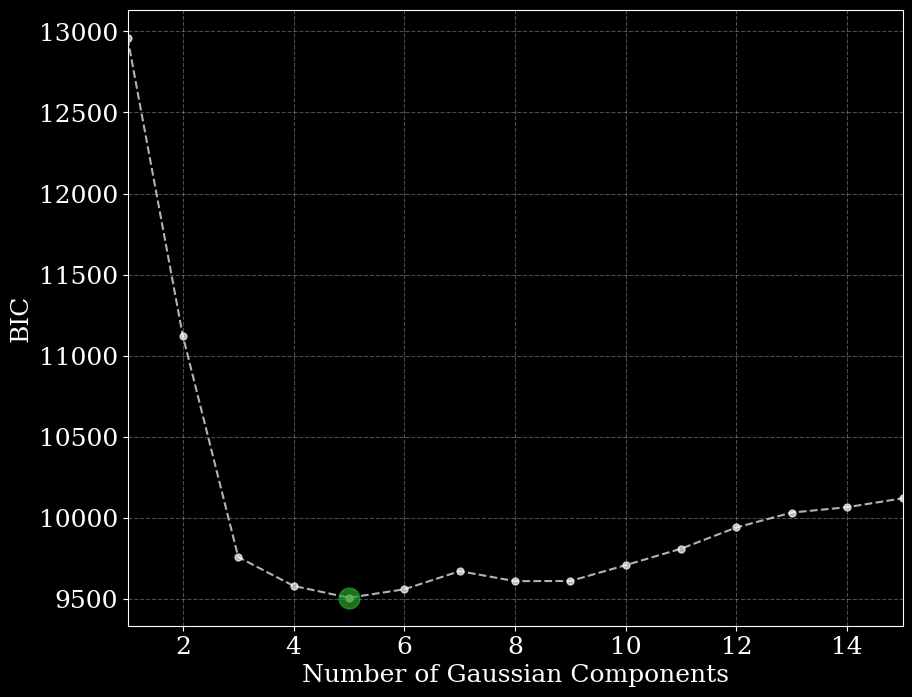

In [ ]:
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

# Plotting the BIC vs. the number of components
plt.figure(figsize=(10, 8))

plt.plot(gmm_results_df["Nr_Comp"],
         gmm_results_df["BIC"],
         linestyle="dashed",
         marker="o",
         markersize=5,
         color="w",
         alpha=0.7)

# Color the minimum value
gmm_results_best = gmm_results_df.loc[gmm_results_df["BIC"] == gmm_results_df["BIC"].min()]
plt.plot(gmm_results_best["Nr_Comp"],
         gmm_results_best["BIC"],
         marker="o",
         markersize=15,
         color="tab:green",
         alpha=0.7)

# Some formatting
plt.xlabel("Number of Gaussian Components")
plt.ylabel("BIC")
plt.grid(linestyle="dashed", alpha=0.3)
plt.xlim(1, max_gauss)

In [ ]:
best_gmm = gmm_results_best["Model"].iloc[0]

# Create a new dataframe column that labels the spectra based on our GMM model:
encoded_df.loc[:, "GMM_Class"] = best_gmm.predict(encoded_df[encoder_space_cols].values)

encoded_df

,enc1,enc2,enc3,enc4,enc5,Main_Group,Bus_Class,GMM_Class
0,-0.12349,0.444634,-1.142225,-1.681923,-1.318036,C,B,4
1,0.484403,-0.407481,-0.047129,0.632053,0.571681,S,S,0
2,-0.294483,1.158337,-0.203964,-1.486838,-1.27338,C,Ch,4
3,-0.048952,0.753443,-0.26915,-1.177055,-1.144733,C,C,4
4,2.445995,-0.885363,-2.091412,0.431602,-0.281428,Other,V,2
...,...,...,...,...,...,...,...,...
1334,0.302738,-0.279914,0.381916,1.443589,1.673146,S,Sl,3
1335,-0.03432,1.288684,-0.414939,-1.415286,-1.33376,C,Ch,4
1336,-0.619398,-0.559329,0.034722,-0.713663,-0.626081,X,Xe,1
1337,-0.365568,-0.260964,-1.460638,-1.002165,-0.990145,C,Cb,1


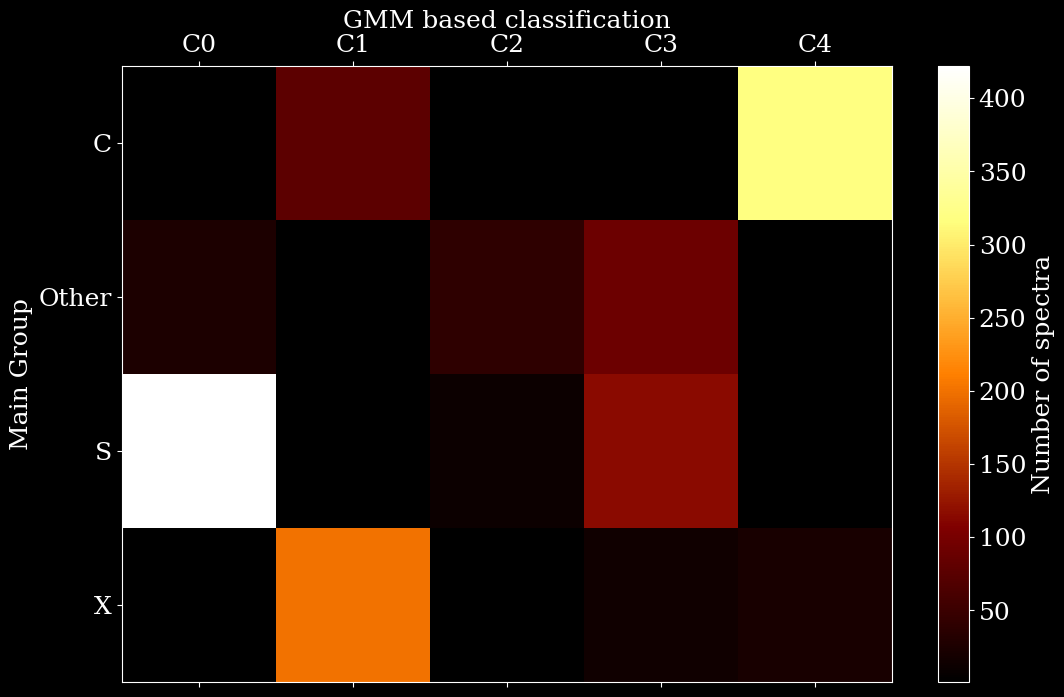

In [ ]:
encoded_grouped_df = pd.crosstab(index=encoded_df["Main_Group"],
                                 columns=encoded_df["GMM_Class"],
                                 values=encoded_df["enc1"],
                                 aggfunc="count")

# Extract data, column and index names for plotting purposes
encoded_grouped_values = encoded_grouped_df.values
encoded_grouped_main = encoded_grouped_df.index.values
encoded_grouped_gmm = [f"C{k}" for k in encoded_grouped_df.columns.values]


# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

# Create a matrix-like plot of the results
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
cax = ax.matshow(encoded_grouped_values, cmap="afmhot")
fig.colorbar(cax, label="Number of spectra", fraction=0.05)

# Some plotting settings
ax.set_xticks(range(len(encoded_grouped_gmm)))
ax.set_yticks(range(len(encoded_grouped_main)))
ax.set_xticklabels(encoded_grouped_gmm)
ax.set_yticklabels(encoded_grouped_main)

ax.set_xlabel("GMM based classification")
ax.set_ylabel("Main Group")
ax.xaxis.set_label_position('top')